In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM, BatchNormalization, CuDNNLSTM, CuDNNGRU, Activation, Flatten
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [3]:
from collections import deque

In [4]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

In [5]:
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('Data/data.dat', sep=' ')

In [7]:
df = df[df['gvkey'] == 1266]
df['year'] = df['year'].map(lambda x: str(x))
df['month'] = df['month'].map(lambda x: str(x))
df['-'] = '-'
df['timestemp'] = df['year'] + df['-'] + df['month']
df['timestemp'] = pd.to_datetime(df['timestemp'])
df = df.set_index('timestemp')
df = df.drop(['active', 'year', 'month', '-', 'date'], axis=1)
df['EBIT'] = df['saleq_ttm'] - df['cogsq_ttm'] - df['xsgaq_ttm']
df['EBIT/EV'] = df['EBIT'] / df['entval']

In [8]:
featureList = ['mom1m','mom3m','cogsq_ttm', 'xsgaq_ttm', 'oiadpq_ttm',
       'niq_ttm', 'cheq_mrq', 'rectq_mrq', 'invtq_mrq', 'acoq_mrq',
       'ppentq_mrq', 'aoq_mrq', 'dlcq_mrq', 'apq_mrq', 'txpq_mrq', 'lcoq_mrq',
       'ltq_mrq', 'seqq_mrq', 'atq_mrq', 'csho_1yr_avg', 'adjusted_price',
       'prccm', 'ajexm']

df.drop(['gvkey', 'gics-sector'], axis=1, inplace=True)
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
df.dropna(inplace=True)

In [9]:
periods = 12

In [10]:
min_max_scaler = preprocessing.MinMaxScaler()
df = pd.DataFrame(min_max_scaler.fit_transform(df), columns=df.columns.values)

df['Y'] = df.iloc[:, -1].shift(periods=-periods)
df.dropna(inplace=True)

In [11]:
seq_df = []
prev_months = deque(maxlen=12)

for i in df.values:
    prev_months.append(i)
    if len(prev_months) == 12:
        seq_df.append(np.array(prev_months))  
        
seq_df = np.array(seq_df)

In [12]:
seq_df.shape

(411, 12, 31)

In [13]:
Y = seq_df[:, -1, -1]
X = seq_df[:, :, :-1]

display(X.shape[1:])
X_temp = X.reshape((X.shape[0], X.shape[1]*X.shape[2]))

display(X_temp[0,[29,59,89]])

(12, 30)

array([0.00899663, 0.08226673, 0.08325124])

In [14]:
X_train = X_temp[:int(len(X)*0.7)]
X_test = X_temp[int(len(X)*0.7):]

Y_train = Y[:int(len(X)*0.7)]
Y_test = Y[int(len(X)*0.7):]

In [15]:
X_test.shape

(124, 360)

In [21]:
lm = LinearRegression()
lm.fit(X_train, Y_train)
pred_train = lm.predict(X_train)
Y_pred = lm.predict(X_test)

In [66]:
display(X_train.shape)
model = Sequential()
model.add(Dense(1, input_shape=(360,)))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

Y_pred = model.predict(X_test)

H = model.fit(X_train, Y_train, epochs=1000, validation_data=(X_test, Y_test))

(287, 360)

Train on 287 samples, validate on 124 samples
Epoch 1/1000
287/287 [==============================] - 0s 2ms/step - loss: 0.1971 - mean_squared_error: 0.1971 - val_loss: 0.4007 - val_mean_squared_error: 0.4007
Epoch 2/1000
287/287 [==============================] - 0s 40us/step - loss: 0.1138 - mean_squared_error: 0.1138 - val_loss: 0.2624 - val_mean_squared_error: 0.2624
Epoch 3/1000
287/287 [==============================] - 0s 44us/step - loss: 0.0681 - mean_squared_error: 0.0681 - val_loss: 0.1140 - val_mean_squared_error: 0.1140
Epoch 4/1000
287/287 [==============================] - 0s 55us/step - loss: 0.0541 - mean_squared_error: 0.0541 - val_loss: 0.0972 - val_mean_squared_error: 0.0972
Epoch 5/1000
287/287 [==============================] - 0s 64us/step - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0902 - val_mean_squared_error: 0.0902
Epoch 6/1000
287/287 [==============================] - 0s 77us/step - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.080

287/287 [==============================] - 0s 59us/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0732 - val_mean_squared_error: 0.0732
Epoch 51/1000
287/287 [==============================] - 0s 65us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0754 - val_mean_squared_error: 0.0754
Epoch 52/1000
287/287 [==============================] - 0s 56us/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0803 - val_mean_squared_error: 0.0803
Epoch 53/1000
287/287 [==============================] - 0s 44us/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0742 - val_mean_squared_error: 0.0742
Epoch 54/1000
287/287 [==============================] - 0s 46us/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0819 - val_mean_squared_error: 0.0819
Epoch 55/1000
287/287 [==============================] - 0s 43us/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0678 - val_mean_squared_error: 0.0678
Epoch 56/1000
287/

287/287 [==============================] - 0s 36us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.1573 - val_mean_squared_error: 0.1573
Epoch 100/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.1245 - val_mean_squared_error: 0.1245
Epoch 101/1000
287/287 [==============================] - 0s 37us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.1449 - val_mean_squared_error: 0.1449
Epoch 102/1000
287/287 [==============================] - 0s 35us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.1510 - val_mean_squared_error: 0.1510
Epoch 103/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.1320 - val_mean_squared_error: 0.1320
Epoch 104/1000
287/287 [==============================] - 0s 41us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.1778 - val_mean_squared_error: 0.1778
Epoch 105/100

287/287 [==============================] - 0s 39us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.2370 - val_mean_squared_error: 0.2370
Epoch 149/1000
287/287 [==============================] - 0s 38us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.2663 - val_mean_squared_error: 0.2663
Epoch 150/1000
287/287 [==============================] - 0s 42us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.1899 - val_mean_squared_error: 0.1899
Epoch 151/1000
287/287 [==============================] - 0s 37us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.1997 - val_mean_squared_error: 0.1997
Epoch 152/1000
287/287 [==============================] - 0s 38us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.2346 - val_mean_squared_error: 0.2346
Epoch 153/1000
287/287 [==============================] - 0s 40us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.2522 - val_mean_squared_error: 0.2522
Epoch 154/100

287/287 [==============================] - 0s 36us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.2408 - val_mean_squared_error: 0.2408
Epoch 198/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.2483 - val_mean_squared_error: 0.2483
Epoch 199/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.3109 - val_mean_squared_error: 0.3109
Epoch 200/1000
287/287 [==============================] - 0s 35us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.3084 - val_mean_squared_error: 0.3084
Epoch 201/1000
287/287 [==============================] - 0s 40us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.2611 - val_mean_squared_error: 0.2611
Epoch 202/1000
287/287 [==============================] - 0s 44us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.2713 - val_mean_squared_error: 0.2713
Epoch 203/100

Epoch 246/1000
287/287 [==============================] - 0s 40us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.3140 - val_mean_squared_error: 0.3140
Epoch 247/1000
287/287 [==============================] - 0s 41us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.3191 - val_mean_squared_error: 0.3191
Epoch 248/1000
287/287 [==============================] - 0s 36us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.2923 - val_mean_squared_error: 0.2923
Epoch 249/1000
287/287 [==============================] - 0s 34us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.2830 - val_mean_squared_error: 0.2830
Epoch 250/1000
287/287 [==============================] - 0s 42us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.2648 - val_mean_squared_error: 0.2648
Epoch 251/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.2893 - val_mean_squared_error: 0.289

287/287 [==============================] - 0s 37us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.3193 - val_mean_squared_error: 0.3193
Epoch 296/1000
287/287 [==============================] - 0s 35us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.2911 - val_mean_squared_error: 0.2911
Epoch 297/1000
287/287 [==============================] - 0s 37us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.3240 - val_mean_squared_error: 0.3240
Epoch 298/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.2995 - val_mean_squared_error: 0.2995
Epoch 299/1000
287/287 [==============================] - 0s 38us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.3457 - val_mean_squared_error: 0.3457
Epoch 300/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.3374 - val_mean_squared_error: 0.3374
Epoch 301/100

287/287 [==============================] - 0s 50us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.3434 - val_mean_squared_error: 0.3434
Epoch 345/1000
287/287 [==============================] - 0s 41us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.3412 - val_mean_squared_error: 0.3412
Epoch 346/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.3187 - val_mean_squared_error: 0.3187
Epoch 347/1000
287/287 [==============================] - 0s 42us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.3234 - val_mean_squared_error: 0.3234
Epoch 348/1000
287/287 [==============================] - 0s 36us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.3348 - val_mean_squared_error: 0.3348
Epoch 349/1000
287/287 [==============================] - 0s 36us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.3196 - val_mean_squared_error: 0.3196
Epoch 350/100

287/287 [==============================] - 0s 37us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.2941 - val_mean_squared_error: 0.2941
Epoch 394/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.3187 - val_mean_squared_error: 0.3187
Epoch 395/1000
287/287 [==============================] - 0s 37us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.3066 - val_mean_squared_error: 0.3066
Epoch 396/1000
287/287 [==============================] - 0s 36us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.3076 - val_mean_squared_error: 0.3076
Epoch 397/1000
287/287 [==============================] - 0s 38us/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.3324 - val_mean_squared_error: 0.3324
Epoch 398/1000
287/287 [==============================] - 0s 35us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.3336 - val_mean_squared_error: 0.3336
Epoch 399/100

287/287 [==============================] - 0s 36us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.3213 - val_mean_squared_error: 0.3213
Epoch 443/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.3127 - val_mean_squared_error: 0.3127
Epoch 444/1000
287/287 [==============================] - 0s 36us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.3039 - val_mean_squared_error: 0.3039
Epoch 445/1000
287/287 [==============================] - 0s 38us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.3317 - val_mean_squared_error: 0.3317
Epoch 446/1000
287/287 [==============================] - 0s 42us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.3098 - val_mean_squared_error: 0.3098
Epoch 447/1000
287/287 [==============================] - 0s 42us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.2994 - val_mean_squared_error: 0.2994
Epoch 448/100

287/287 [==============================] - 0s 35us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.3080 - val_mean_squared_error: 0.3080
Epoch 492/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.3236 - val_mean_squared_error: 0.3236
Epoch 493/1000
287/287 [==============================] - 0s 37us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.3144 - val_mean_squared_error: 0.3144
Epoch 494/1000
287/287 [==============================] - 0s 34us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.3183 - val_mean_squared_error: 0.3183
Epoch 495/1000
287/287 [==============================] - 0s 38us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.3188 - val_mean_squared_error: 0.3188
Epoch 496/1000
287/287 [==============================] - 0s 36us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.3109 - val_mean_squared_error: 0.3109
Epoch 497/100

287/287 [==============================] - 0s 37us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.2750 - val_mean_squared_error: 0.2750
Epoch 541/1000
287/287 [==============================] - 0s 36us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.2835 - val_mean_squared_error: 0.2835
Epoch 542/1000
287/287 [==============================] - 0s 42us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.2976 - val_mean_squared_error: 0.2976
Epoch 543/1000
287/287 [==============================] - 0s 40us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.2970 - val_mean_squared_error: 0.2970
Epoch 544/1000
287/287 [==============================] - 0s 37us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.2981 - val_mean_squared_error: 0.2981
Epoch 545/1000
287/287 [==============================] - 0s 37us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.3189 - val_mean_squared_error: 0.3189
Epoch 546/100

287/287 [==============================] - 0s 36us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.2925 - val_mean_squared_error: 0.2925
Epoch 590/1000
287/287 [==============================] - 0s 40us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.2972 - val_mean_squared_error: 0.2972
Epoch 591/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.2865 - val_mean_squared_error: 0.2865
Epoch 592/1000
287/287 [==============================] - 0s 35us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.2823 - val_mean_squared_error: 0.2823
Epoch 593/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.2851 - val_mean_squared_error: 0.2851
Epoch 594/1000
287/287 [==============================] - 0s 36us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.2843 - val_mean_squared_error: 0.2843
Epoch 595/100

287/287 [==============================] - 0s 36us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.2685 - val_mean_squared_error: 0.2685
Epoch 639/1000
287/287 [==============================] - 0s 35us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.2846 - val_mean_squared_error: 0.2846
Epoch 640/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.2941 - val_mean_squared_error: 0.2941
Epoch 641/1000
287/287 [==============================] - 0s 37us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.2988 - val_mean_squared_error: 0.2988
Epoch 642/1000
287/287 [==============================] - 0s 35us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.2909 - val_mean_squared_error: 0.2909
Epoch 643/1000
287/287 [==============================] - 0s 38us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.2881 - val_mean_squared_error: 0.2881
Epoch 644/100

287/287 [==============================] - 0s 38us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.3002 - val_mean_squared_error: 0.3002
Epoch 688/1000
287/287 [==============================] - 0s 35us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.2838 - val_mean_squared_error: 0.2838
Epoch 689/1000
287/287 [==============================] - 0s 35us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.2836 - val_mean_squared_error: 0.2836
Epoch 690/1000
287/287 [==============================] - 0s 38us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.2862 - val_mean_squared_error: 0.2862
Epoch 691/1000
287/287 [==============================] - 0s 36us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.2839 - val_mean_squared_error: 0.2839
Epoch 692/1000
287/287 [==============================] - 0s 35us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.2903 - val_mean_squared_error: 0.2903
Epoch 693/100

287/287 [==============================] - 0s 40us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.2769 - val_mean_squared_error: 0.2769
Epoch 737/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.2751 - val_mean_squared_error: 0.2751
Epoch 738/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.2758 - val_mean_squared_error: 0.2758
Epoch 739/1000
287/287 [==============================] - 0s 35us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.2715 - val_mean_squared_error: 0.2715
Epoch 740/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.2759 - val_mean_squared_error: 0.2759
Epoch 741/1000
287/287 [==============================] - 0s 36us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.2729 - val_mean_squared_error: 0.2729
Epoch 742/100

287/287 [==============================] - 0s 40us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.2963 - val_mean_squared_error: 0.2963
Epoch 786/1000
287/287 [==============================] - 0s 38us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.2873 - val_mean_squared_error: 0.2873
Epoch 787/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.2841 - val_mean_squared_error: 0.2841
Epoch 788/1000
287/287 [==============================] - 0s 35us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.2806 - val_mean_squared_error: 0.2806
Epoch 789/1000
287/287 [==============================] - 0s 37us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.2743 - val_mean_squared_error: 0.2743
Epoch 790/1000
287/287 [==============================] - 0s 37us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.2818 - val_mean_squared_error: 0.2818
Epoch 791/100

287/287 [==============================] - 0s 38us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.2727 - val_mean_squared_error: 0.2727
Epoch 835/1000
287/287 [==============================] - 0s 38us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.2732 - val_mean_squared_error: 0.2732
Epoch 836/1000
287/287 [==============================] - 0s 35us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.2722 - val_mean_squared_error: 0.2722
Epoch 837/1000
287/287 [==============================] - 0s 38us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.2727 - val_mean_squared_error: 0.2727
Epoch 838/1000
287/287 [==============================] - 0s 36us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.2709 - val_mean_squared_error: 0.2709
Epoch 839/1000
287/287 [==============================] - 0s 32us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.2744 - val_mean_squared_error: 0.2744
Epoch 840/100

287/287 [==============================] - 0s 36us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.2814 - val_mean_squared_error: 0.2814
Epoch 884/1000
287/287 [==============================] - 0s 37us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.2693 - val_mean_squared_error: 0.2693
Epoch 885/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.2690 - val_mean_squared_error: 0.2690
Epoch 886/1000
287/287 [==============================] - 0s 37us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.2669 - val_mean_squared_error: 0.2669
Epoch 887/1000
287/287 [==============================] - 0s 35us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.2720 - val_mean_squared_error: 0.2720
Epoch 888/1000
287/287 [==============================] - 0s 40us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.2726 - val_mean_squared_error: 0.2726
Epoch 889/100

287/287 [==============================] - 0s 40us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.2784 - val_mean_squared_error: 0.2784
Epoch 933/1000
287/287 [==============================] - 0s 36us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.2685 - val_mean_squared_error: 0.2685
Epoch 934/1000
287/287 [==============================] - 0s 35us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.2650 - val_mean_squared_error: 0.2650
Epoch 935/1000
287/287 [==============================] - 0s 39us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.2662 - val_mean_squared_error: 0.2662
Epoch 936/1000
287/287 [==============================] - 0s 36us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.2685 - val_mean_squared_error: 0.2685
Epoch 937/1000
287/287 [==============================] - 0s 35us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.2607 - val_mean_squared_error: 0.2607
Epoch 938/100

287/287 [==============================] - 0s 39us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.2568 - val_mean_squared_error: 0.2568
Epoch 982/1000
287/287 [==============================] - 0s 40us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.2620 - val_mean_squared_error: 0.2620
Epoch 983/1000
287/287 [==============================] - 0s 37us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.2643 - val_mean_squared_error: 0.2643
Epoch 984/1000
287/287 [==============================] - 0s 36us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.2664 - val_mean_squared_error: 0.2664
Epoch 985/1000
287/287 [==============================] - 0s 40us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.2696 - val_mean_squared_error: 0.2696
Epoch 986/1000
287/287 [==============================] - 0s 37us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.2682 - val_mean_squared_error: 0.2682
Epoch 987/100

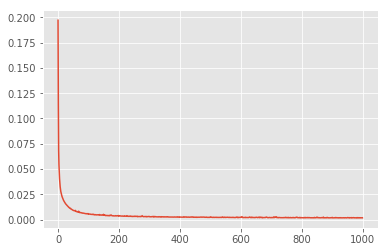

In [67]:
plt.plot(H.history['mean_squared_error'])

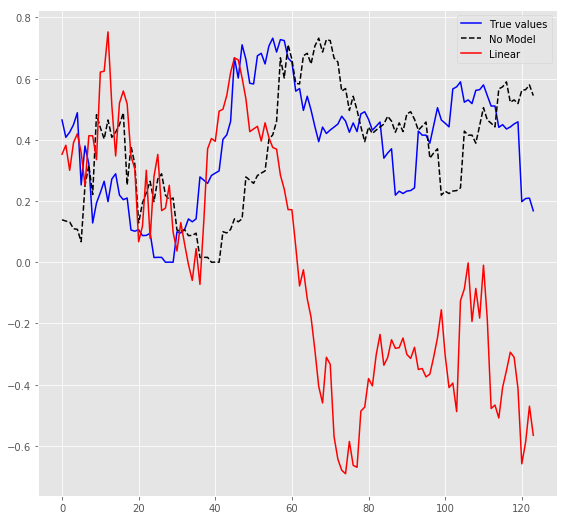

In [68]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 9))
ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
ax.plot(Y_test, label='True values', color='blue')
ax.plot(X_test[:, -1], label='No Model', linestyle='--', color='black')
ax.plot(Y_pred, label='Linear', color='red')
ax.legend()
plt.show()